### xgboost model to predict mean player outcomes
used in conjunction with nn algs to determine mean wrc for player. Three diffrent models based on available data then combinded to create an xgb predection.

In [18]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import sys
function_dir = 'C:/Users/dalto/OneDrive/Pictures/Documents/Projects/MLB Season Model/tools'
sys.path.append(function_dir)

os.chdir('C:/Users/dalto/OneDrive/Pictures/Documents/Projects/MLB Season Model/')

In [19]:
# import data
data_02_24 = pd.read_csv('./data/cleaned/data_02_24.csv')
df = data_02_24.drop(columns=['Unnamed: 0'])
df = df.dropna()

#### Normalize Data



In [20]:
from tools.zscore import normalize
z_score_df = normalize(df)

### xgboost model

In [21]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

make wrc+ value the next year

In [22]:
# remove 2024 to train model bc we do not know the following year
train_z = z_score_df[z_score_df['Season'] < 2024].copy()
train_z['next_wrc+'] = np.nan # empty col


for idx in train_z.index:
    # retrive name, season
    name = train_z.loc[idx, 'Name']
    season = train_z.loc[idx, 'Season']
    # full df
    next_year_noscale = df[(df['Name'] == name) & (df['Season'] == season + 1)]
    next_year_scaled = z_score_df[(z_score_df['Name'] == name) & (z_score_df['Season'] == season + 1)]

    # add to df
    if not next_year_noscale.empty:
        train_z.loc[idx, 'next_wrc+'] = next_year_noscale['wRC+'].iloc[0]
        train_z.loc[idx, 'next_pa'] = next_year_noscale['PA'].iloc[0] # need for later anaylsis

# remove rows of nas | players retired etc.
train_z = train_z.dropna(subset=['next_wrc+'])

# display
train_z.head()

,Name,Season,PA,Age,BB%,K%,BABIP,wRC+,BsR,Off,...,WAR,O-Swing%,Z-Swing%,O-Contact%,Z-Contact%,Contact%,SwStr%,CSW%,next_wrc+,next_pa
0,brent clevlen,2007,74.826870,85.958971,74.686219,193.060161,107.344122,43.282571,98.653170,96.363387,...,89.901996,138.703183,88.950287,71.666459,22.211544,37.187201,169.893575,204.596460,40.620897,28.0
1,brett hayes,2009,74.297907,90.367791,72.475999,127.859623,108.219882,117.931506,99.866315,98.235778,...,91.580480,170.668602,80.735141,60.421763,105.381033,65.578050,147.469352,199.428878,68.663763,83.0
2,carlos peguero,2014,75.723755,96.257739,107.348483,147.612705,148.436984,92.738037,100.377615,97.711317,...,91.256604,122.457976,73.452584,41.259125,91.336666,33.462464,156.578380,183.278087,92.949027,90.0
5,domingo santana,2014,76.161502,80.937328,92.701724,191.474452,27.049843,35.300547,100.388715,95.262033,...,88.346507,104.533169,117.006084,37.346862,46.681858,34.973860,163.064364,174.135337,111.757590,187.0
8,eliezer alfonzo,2008,75.550163,100.406271,73.751790,132.428726,56.320994,41.119256,98.386518,95.994778,...,89.755634,150.740042,83.057646,74.748966,56.559446,48.895200,160.671646,180.916565,19.347656,117.0


inject noise to next_pa
<br>
<small> I want to mimmic the accuracy of my projection model so that next_pa is not overweighted as a feature.

In [23]:
num_points = len(train_z['next_pa'])
noise = np.random.normal(loc=0, scale=75, size=num_points)  # corresponds to less than 0.8 std which is how much model misses on avg
train_z['next_pa'] = train_z['next_pa'] + noise
train_z['next_pa'] = train_z['next_pa'].clip(lower=10, upper=735)
train_z.head()

,Name,Season,PA,Age,BB%,K%,BABIP,wRC+,BsR,Off,...,WAR,O-Swing%,Z-Swing%,O-Contact%,Z-Contact%,Contact%,SwStr%,CSW%,next_wrc+,next_pa
0,brent clevlen,2007,74.826870,85.958971,74.686219,193.060161,107.344122,43.282571,98.653170,96.363387,...,89.901996,138.703183,88.950287,71.666459,22.211544,37.187201,169.893575,204.596460,40.620897,10.000000
1,brett hayes,2009,74.297907,90.367791,72.475999,127.859623,108.219882,117.931506,99.866315,98.235778,...,91.580480,170.668602,80.735141,60.421763,105.381033,65.578050,147.469352,199.428878,68.663763,75.076051
2,carlos peguero,2014,75.723755,96.257739,107.348483,147.612705,148.436984,92.738037,100.377615,97.711317,...,91.256604,122.457976,73.452584,41.259125,91.336666,33.462464,156.578380,183.278087,92.949027,21.114198
5,domingo santana,2014,76.161502,80.937328,92.701724,191.474452,27.049843,35.300547,100.388715,95.262033,...,88.346507,104.533169,117.006084,37.346862,46.681858,34.973860,163.064364,174.135337,111.757590,225.154549
8,eliezer alfonzo,2008,75.550163,100.406271,73.751790,132.428726,56.320994,41.119256,98.386518,95.994778,...,89.755634,150.740042,83.057646,74.748966,56.559446,48.895200,160.671646,180.916565,19.347656,78.261022


intial selection of data before feature selection

In [24]:
train_z = train_z[train_z['Season'] < 2024]
X = train_z.drop(columns=['Name', 'Season','next_wrc+', 'BsR', 'Def', 'Age'])
Y = train_z['next_wrc+']
xtrain, xtest, ytrain, ytest = train_test_split(X, Y, test_size=0.25, random_state=26)

train test split

In [30]:
xtrain, xtest, ytrain, ytest = train_test_split(X, Y, test_size=0.25, random_state=26)

In [31]:
# Calculate correlation matrix
corr = train_z.corr(numeric_only=True)

# next_wrc+ corr
corr_with_wrc = corr['next_wrc+'].sort_values(ascending=False)

print(corr_with_wrc)

next_wrc+     1.000000
next_pa       0.517668
Off           0.382569
WAR           0.381704
PA            0.361969
wRC+          0.345374
BB%           0.219980
BABIP         0.109904
Contact%      0.053054
O-Contact%    0.048914
Z-Contact%    0.034933
Z-Swing%      0.031965
Season        0.000939
BsR          -0.002778
Age          -0.017348
SwStr%       -0.082973
Def          -0.105743
K%           -0.107718
O-Swing%     -0.123050
CSW%         -0.153511
Name: next_wrc+, dtype: float64


In [32]:
model = xgb.XGBRegressor(n_jobs=-1, n_estimators=50000, device = "cuda", eval_metric = ['mae', 'rmse']) 

##### hyper para tuning

random search to narrow space into grid search

In [28]:
from sklearn.model_selection import RandomizedSearchCV

In [29]:
rnd_search_params = {
    'learning_rate': np.linspace(0.05, 0.2, 4),          
    'max_leaves': np.linspace(1, 40, 20, dtype=int),     
    'min_child_weight': np.linspace(1, 20, 10),         
    'subsample': np.linspace(0.3, 0.9, 7),               
    'colsample_bytree': np.linspace(0.4, 1, 7),          
    'early_stopping_rounds': np.linspace(10, 100, 10, dtype=int),  
    'max_depth': np.linspace(0, 40, 20, dtype=int)       
}

rnd_searcher = RandomizedSearchCV(model, rnd_search_params, random_state=26, n_iter=250, cv=5, n_jobs=-1, verbose=4)
rnd_searcher.fit(xtrain, ytrain, eval_set=[(xtest, ytest)])
print(rnd_searcher.best_params_)

Fitting 5 folds for each of 250 candidates, totalling 1250 fits


KeyboardInterrupt: 

grid search

In [ ]:
from sklearn.model_selection import GridSearchCV
grid_search_params = {
    'learning_rate': [0.05, 0.1],   
    'max_leaves': [10, 12, 14],
    'min_child_weight': [10, 11, 12],      
    'subsample': [0.4, 0.5, 0.6],           
    'colsample_bytree':[0.7, 0.8, 0.9],     
    'early_stopping_rounds':[40, 50, 60],
    'max_depth': [2, 3, 4]
}

In [ ]:
grid_searcher = GridSearchCV(model, grid_search_params, cv=5, n_jobs=-1, verbose=4)
grid_searcher.fit(xtrain, ytrain, eval_set=[(xtest, ytest)])
print(grid_searcher.best_params_)

Fitting 5 folds for each of 1458 candidates, totalling 7290 fits
[0]	validation_0-mae:29.02709	validation_0-rmse:39.24734
[1]	validation_0-mae:28.75311	validation_0-rmse:38.93006
[2]	validation_0-mae:28.49083	validation_0-rmse:38.62693
[3]	validation_0-mae:28.24847	validation_0-rmse:38.33888
[4]	validation_0-mae:28.03798	validation_0-rmse:38.09798
[5]	validation_0-mae:27.84207	validation_0-rmse:37.87629
[6]	validation_0-mae:27.66408	validation_0-rmse:37.66678
[7]	validation_0-mae:27.51224	validation_0-rmse:37.48545
[8]	validation_0-mae:27.35714	validation_0-rmse:37.30446
[9]	validation_0-mae:27.21828	validation_0-rmse:37.12731
[10]	validation_0-mae:27.09402	validation_0-rmse:36.98753
[11]	validation_0-mae:26.98714	validation_0-rmse:36.86098
[12]	validation_0-mae:26.86619	validation_0-rmse:36.72291
[13]	validation_0-mae:26.76819	validation_0-rmse:36.60464
[14]	validation_0-mae:26.66981	validation_0-rmse:36.48465
[15]	validation_0-mae:26.59986	validation_0-rmse:36.39575
[16]	validation_0

c:\Users\dalto\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:01:28] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[32]	validation_0-mae:25.72157	validation_0-rmse:35.34697
[33]	validation_0-mae:25.70125	validation_0-rmse:35.32011
[34]	validation_0-mae:25.67403	validation_0-rmse:35.28284
[35]	validation_0-mae:25.66619	validation_0-rmse:35.27073
[36]	validation_0-mae:25.64684	validation_0-rmse:35.24754
[37]	validation_0-mae:25.62243	validation_0-rmse:35.21811
[38]	validation_0-mae:25.60515	validation_0-rmse:35.18815
[39]	validation_0-mae:25.59280	validation_0-rmse:35.16932
[40]	validation_0-mae:25.57870	validation_0-rmse:35.15223
[41]	validation_0-mae:25.56098	validation_0-rmse:35.13439
[42]	validation_0-mae:25.54226	validation_0-rmse:35.11168
[43]	validation_0-mae:25.53265	validation_0-rmse:35.09686
[44]	validation_0-mae:25.51378	validation_0-rmse:35.07058
[45]	validation_0-mae:25.50479	validation_0-rmse:35.06206
[46]	validation_0-mae:25.50668	validation_0-rmse:35.06116
[47]	validation_0-mae:25.49168	validation_0-rmse:35.04557
[48]	validation_0-mae:25.47789	validation_0-rmse:35.03364
[49]	validatio

In [33]:
opti_para = {'colsample_bytree': 0.7, 'early_stopping_rounds': 30, 'learning_rate': 0.05, 'max_depth': 3, 'max_leaves': 7, 'min_child_weight': 10, 'subsample': 0.6}
# update model parameters
model.set_params(**opti_para)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device='cuda', early_stopping_rounds=30,
             enable_categorical=False, eval_metric=['mae', 'rmse'],
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=7, min_child_weight=10, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=50000,
             n_jobs=-1, num_parallel_tree=None, random_state=None, ...)

xgb.cv for detailed analysis, optimal boosting rounds

In [ ]:
matrix_data = xgb.DMatrix(X, Y)
fmodel = xgb.cv(opti_para, dtrain=matrix_data, num_boost_round=1000, nfold=10, metrics= ['rmse', 'mae'], as_pandas=True, seed=26, early_stopping_rounds=30)
fmodel.head()

c:\Users\dalto\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:15:22] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "early_stopping_rounds" } are not used.

  warnings.warn(smsg, UserWarning)


,train-rmse-mean,train-rmse-std,train-mae-mean,train-mae-std,test-rmse-mean,test-rmse-std,test-mae-mean,test-mae-std
0,38.477683,0.169055,28.356506,0.115368,38.460386,1.507674,28.365301,0.934532
1,37.968773,0.159151,27.916441,0.111522,37.970463,1.493517,27.942025,0.925093
2,37.477120,0.155031,27.496837,0.109002,37.488037,1.483009,27.529650,0.922397
3,37.024588,0.153760,27.115582,0.109127,37.049884,1.468733,27.157901,0.921658
4,36.742865,0.150955,26.871490,0.108079,36.774189,1.467382,26.917968,0.916436


#### opti model

In [34]:
# update model parameters
model.set_params(**opti_para)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device='cuda', early_stopping_rounds=30,
             enable_categorical=False, eval_metric=['mae', 'rmse'],
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=7, min_child_weight=10, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=50000,
             n_jobs=-1, num_parallel_tree=None, random_state=None, ...)

In [35]:
model.set_params(n_estimators=150, early_stopping_rounds=None)
model.fit(xtrain, ytrain)
ypreds = model.predict(xtest)

c:\Users\dalto\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:44:50] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


##### Results DF

In [36]:
results_df = xtest.copy()
results_df['Name'] = train_z.loc[xtest.index, 'Name']
results_df['Season'] = train_z.loc[xtest.index, 'Season']
results_df['next_pa'] = train_z.loc[xtest.index, 'next_pa']
results_df['pred_wrc+'] = ypreds
results_df['season_plus1_wrc+'] = ytest
results_df = results_df[['Name', 'Season', 'pred_wrc+', 'season_plus1_wrc+', 'next_pa']]
results_df['miss'] = (results_df['season_plus1_wrc+'] - results_df['pred_wrc+']).abs()
results_df.head()

,Name,Season,pred_wrc+,season_plus1_wrc+,next_pa,miss
12473,scooter gennett,2015,89.876343,92.114351,522.041597,2.238008
9093,manny machado,2023,116.723404,121.960891,735.000000,5.237487
9240,barry larkin,2003,83.265160,99.415008,298.889432,16.149848
11548,edwin encarnacion,2011,113.166969,150.162933,735.000000,36.995963
10022,oswaldo cabrera,2023,81.364700,87.606563,374.282910,6.241863


##### Model Eval

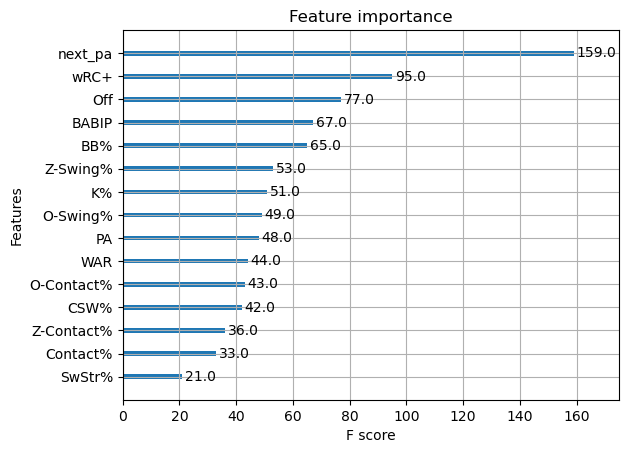

In [37]:
xgb.plot_importance(model)
plt.show()

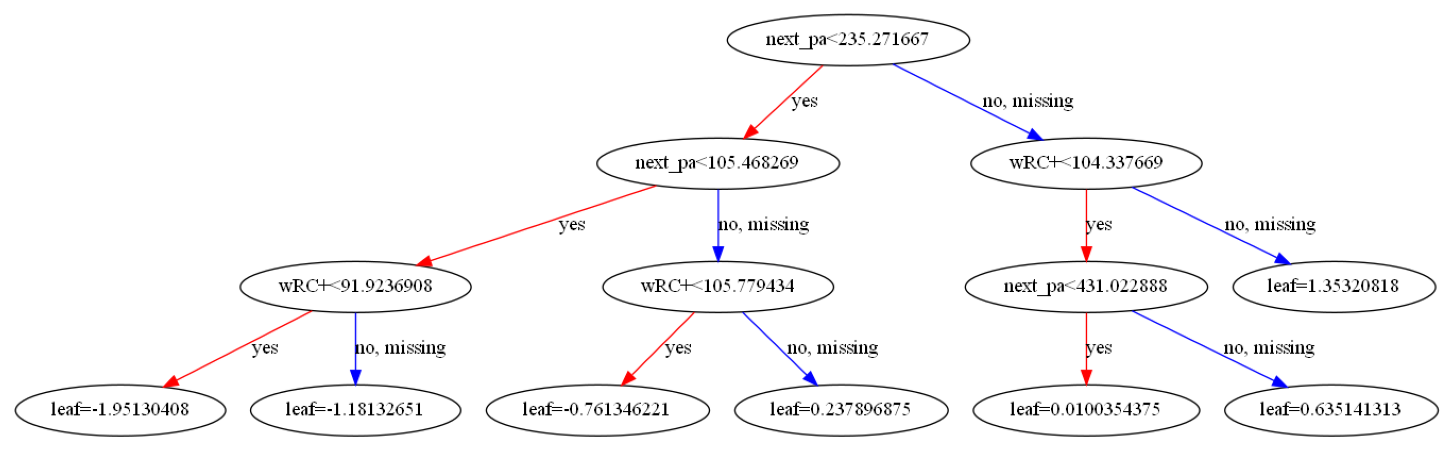

In [38]:
xgb.plot_tree(model, num_trees=1)
plt.gcf().set_size_inches(18.5, 10.5)
plt.show()

#### Metrics

In [39]:
from sklearn.metrics import r2_score, root_mean_squared_error, mean_absolute_error

r2 = r2_score(y_true=ytest, y_pred=ypreds)
mae = mean_absolute_error(y_true=ytest, y_pred=ypreds)
rmse = root_mean_squared_error(y_true=ytest, y_pred=ypreds)

print(f"R^2: {r2} \n mse: {mae} \n rmse: {rmse}")

R^2: 0.3159386125694862 
 mse: 22.470306341881763 
 rmse: 31.905993998902748


#### 2025 Predections

In [40]:
next_pa = pd.read_csv('./predicted_data/pa_25.csv')
next_pa = next_pa.drop(columns=['Unnamed: 0'])

In [41]:
weighted_02_24 = pd.read_csv('./data/multi_season/weighted_02_24.csv')
weighted_02_24 = weighted_02_24.drop(columns=['Unnamed: 0'])
weighted_02_24 = normalize(weighted_02_24)

In [42]:
season = z_score_df[z_score_df['Season'] >= 2024].copy()
season = season.reset_index()
season = season.merge(next_pa, on='Name', how='left')
season = season.rename(columns={'avg_pred_pa':'next_pa'})
season = season.drop(columns=['index'])
season = season[train_z.drop(columns=['next_wrc+']).columns]

In [43]:
season_pred = season.drop(columns=['Name', 
                                    'BsR', 'Def', 
                                   'Season', 'Age'])

In [44]:
preds_2025 = model.predict(season_pred)
preds_2025 = pd.DataFrame(preds_2025)
preds_2025['Name'] = season['Name']

In [45]:
preds_2025.to_csv('./predicted_data/wrc_pred/reg_02_23_preds.csv')